In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import seaborn as sns

from RegressionFunc import *

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2 

In [5]:
df = pd.read_csv('../data/gfs_days.csv', sep = ';', index_col = 'Date', parse_dates = ['Date'])

# Температурные инверсии
df['DT1'] = df['TMP_mb_1000'] - df['TMP_mb_925']
df['DT2'] = df['TMP_mb_925'] - df['TMP_mb_850']
df['DT3'] = df['TMP_mb_1000'] - df['TMP_mb_850']

In [6]:
X = df.values

### Стандартизация признаков

In [7]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

### Вычисление ковариационной матрицы, а также собственных векторов и собственных значений

In [8]:
cov_mat = np.cov(X_std.T)

In [9]:
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

### Кумулятивная сумма объясненных дисперсий

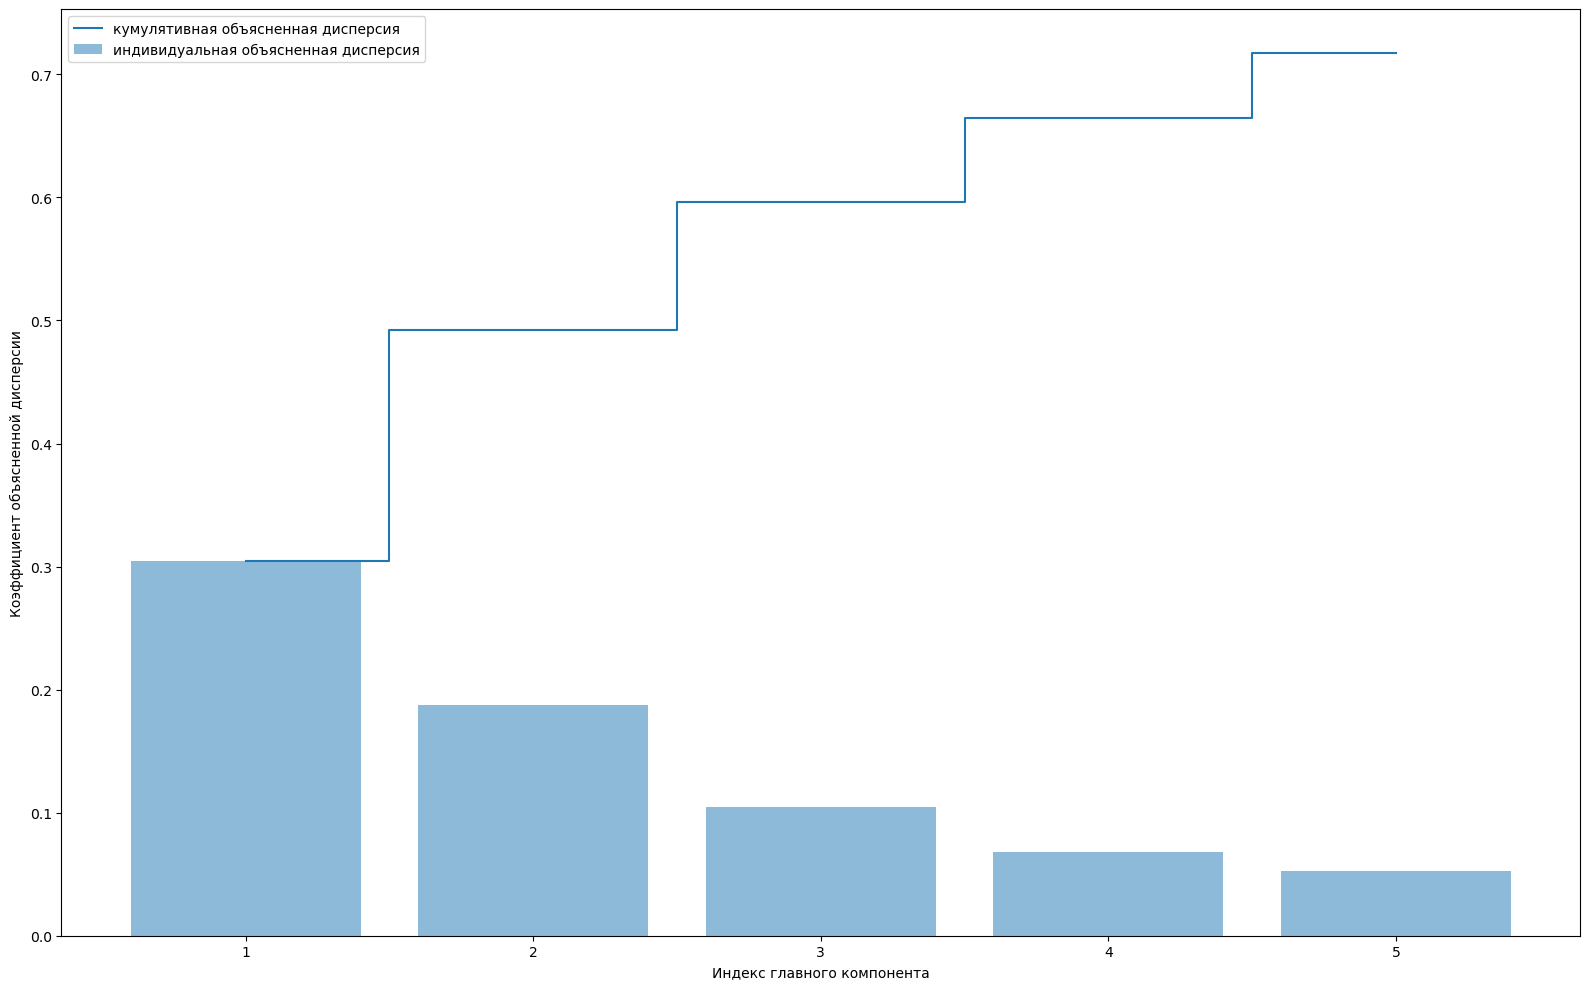

In [10]:
tot = sum(eigen_vals) # Сумма собственных значений
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)] # Доля объяснённой дисперсии
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize = (16, 10))
plt.bar(range(1,6), var_exp[:5], alpha = 0.5, align = 'center', label = 'индивидуальная объясненная дисперсия')
plt.step(range(1,6), cum_var_exp[:5], where ='mid', label = 'кумулятивная объясненная дисперсия')
plt.ylabel('Коэффициент объясненной дисперсии')
plt.xlabel('Индекс главного компонента')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show() 

In [11]:
# Определение числа главных компонент, объясняющих 80% дисперсии
def countPca(eig_vals):
    s = sum(eig_vals)
    tempS = 0
    k = 1
    for val in sorted(eig_vals, reverse = True):
        tempS += val
        print(f'{k}-я главная компонента объясняет {round(val/s*100, 2)}% дисперсии')
        if tempS / s >= 0.80:
            print(f'Первые {k} главных компонент объясняют {round(tempS / s * 100, 2)}% дисперсии')
            return k
        k += 1

In [12]:
k = countPca(eigen_vals)

1-я главная компонента объясняет 30.47% дисперсии
2-я главная компонента объясняет 18.74% дисперсии
3-я главная компонента объясняет 10.43% дисперсии
4-я главная компонента объясняет 6.82% дисперсии
5-я главная компонента объясняет 5.26% дисперсии
6-я главная компонента объясняет 3.73% дисперсии
7-я главная компонента объясняет 2.63% дисперсии
8-я главная компонента объясняет 2.05% дисперсии
Первые 8 главных компонент объясняют 80.14% дисперсии


### Сортировка собственных пар в порядке убывания собственных значений

In [13]:
# Cоздать список кортежей (собственное значение, собственный вектор)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Oтсортировать кортежи (собственное значение, собственный вектор) от высоких к низким
eigen_pairs.sort(key=lambda k: k[0], reverse = True) 
#eigen_pairs

### Соберем 8 собственных векторов, которые соответствуют 8 наибольшим собственным значениям, чтобы захватить около 80% дисперсии в наборе данных

In [14]:
w = np.hstack([eigen_pairs[i][1] [:, np.newaxis] for i in range(k)])

In [15]:
pd.DataFrame(w)

,0,1,2,3,4,5,6,7
0,-0.111222,0.066672,-0.028016,-0.035502,0.042287,-0.042455,0.026309,-0.109305
1,-0.017966,-0.012426,0.083494,0.050304,0.042881,0.042460,0.206404,-0.063914
2,-0.019117,-0.014159,0.076837,0.054229,-0.009303,0.020635,0.244029,-0.052351
3,-0.018669,-0.006155,0.059514,0.050374,-0.048786,-0.001426,0.255612,-0.017581
4,-0.000327,0.023166,0.052992,0.042892,-0.074283,0.000467,0.238430,0.036982
...,...,...,...,...,...,...,...,...
157,-0.013749,0.012428,-0.028705,0.010718,0.007449,0.049473,-0.019827,0.025594
158,-0.100495,0.045137,-0.035182,0.074194,-0.016017,-0.067229,-0.026916,0.120939
159,0.031973,-0.094354,0.128526,-0.053488,0.064465,0.046496,0.085308,-0.049971
160,0.074281,-0.077576,0.054616,-0.042293,0.116325,0.089362,-0.009118,-0.008289


## Определение весов, с которыми признаки входят в первые 5 главные компоненты

In [16]:
names = pd.read_csv('../data/Names.csv', header = None)
names

,0,1
0,4LFTX,Лучший (4-слойный) индекс поднятия над поверхн...
1,ABSV_mb_700,Абсолютная завихренность на 700mb (1/сек)
2,ABSV_mb_750,Абсолютная завихренность на 750mb (1/сек)
3,ABSV_mb_800,Абсолютная завихренность на 800mb (1/сек)
4,ABSV_mb_850,Абсолютная завихренность на 850mb (1/сек)
...,...,...
171,WEASD,Водный эквивалент накопленной толщины снежного...
172,WILT,Tочка увядания (доля)
173,DT1,Приземные и приподнятые инверсии
174,DT2,Высотные инверсии


In [17]:
descr = []
for col in df.columns:
    if col in names[0].values:
        descr.append(names[names[0]==col][1].values[0])

In [18]:
weights = pd.DataFrame(index = df.columns)
weights['Расшифровка'] = descr
for i in range(5):
    weights[f'{i+1} компонента'] = abs(w[:, i]) # Взятие модуля

In [19]:
weights.sort_values(by='1 компонента', ascending=False).iloc[:, [0, 1]]

,Расшифровка,1 компонента
TMP_mb_900,Температура на 900mb (К),0.132012
TMP_mb_925,Температура на 925mb (К),0.131761
TMP_mb_850,Температура на 850mb (К),0.131569
TMP_msl_1829,Температура на 1829 м над уровнем моря (К),0.131158
APTMP,Кажущаяся температура (К),0.130859
...,...,...
SOILW_g_04_10,Объемная влажность почвы на 0.4-1 м над землёй...,0.005843
HGT_max_wind,Геопотенциальная высота при макс. ветре (гал/мин),0.004244
VVEL_mb_850,Вертикальная завихренность на 850mb (Па/сек),0.003667
CWAT,Облачная вода (кг/м^2),0.001325


### Трансформируем весь  набор данных в 8 главных компонент, вычислив скалярное произведение матриц X'=XW

In [20]:
X_pca = X_std.dot(w)

In [21]:
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7
0,-5.628992,7.066759,0.467623,1.703191,-1.799131,2.415477,-2.291610,2.213015
1,-8.456753,5.679653,1.585698,0.530149,-2.234650,3.057382,-1.706325,3.345341
2,-8.502123,6.797718,1.272193,0.330103,-1.078282,3.150221,0.861095,1.902134
3,-5.117580,8.955937,-5.221970,2.310108,1.590680,0.233557,0.042851,2.278930
4,-9.383417,2.343389,-2.709950,-0.232306,0.313365,0.243203,-1.324260,3.166576
...,...,...,...,...,...,...,...,...
1900,-8.613770,-1.373161,2.467891,0.601614,1.380883,2.718716,-0.936691,0.503069
1901,-9.728488,-6.247470,-3.776891,-1.168846,0.252975,3.760993,3.079389,0.617772
1902,-8.533600,-4.961109,3.848562,-5.074769,-1.799779,0.121468,2.169650,1.273623
1903,-6.844005,-5.918183,-1.731719,-3.942162,-4.609305,0.694076,1.376998,1.941342


## Данные PM 2.5

In [25]:
# Среднесуточные данные PM 2.5
sensor = 'm'
dfAll = pd.read_csv(f"../data/pm25_{sensor}_fill.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'])
pm = dfAll['Mean']

In [26]:
# Количество пропусков в данных
pm.isnull().sum()

0

In [27]:
# Добавим колонку pm, чтобы затем удалить пропуски во всех данных
X = pd.DataFrame(X_pca)
X.index = pm.index
X['pm'] = pm.values
X

,0,1,2,3,4,5,6,7,pm
Date,,,,,,,,,
2019-01-01,-5.628992,7.066759,0.467623,1.703191,-1.799131,2.415477,-2.291610,2.213015,88.40
2019-01-02,-8.456753,5.679653,1.585698,0.530149,-2.234650,3.057382,-1.706325,3.345341,33.99
2019-01-03,-8.502123,6.797718,1.272193,0.330103,-1.078282,3.150221,0.861095,1.902134,9.36
2019-01-04,-5.117580,8.955937,-5.221970,2.310108,1.590680,0.233557,0.042851,2.278930,44.34
2019-01-05,-9.383417,2.343389,-2.709950,-0.232306,0.313365,0.243203,-1.324260,3.166576,62.41
...,...,...,...,...,...,...,...,...,...
2024-03-15,-8.613770,-1.373161,2.467891,0.601614,1.380883,2.718716,-0.936691,0.503069,14.80
2024-03-16,-9.728488,-6.247470,-3.776891,-1.168846,0.252975,3.760993,3.079389,0.617772,10.79
2024-03-17,-8.533600,-4.961109,3.848562,-5.074769,-1.799779,0.121468,2.169650,1.273623,6.77


In [28]:
# Удаление пропусков
X.dropna(inplace = True)

### Корреляция главных компонент с PM 2.5

# Диаграммы рассеяния

# Линейная регрессия

In [29]:
fileName = 'XGBoost.xlsx'

# Регрессия на новые признаки (компоненты)

In [30]:
for season in ['winters', 'springs', 'summers', 'autumns']:
    data = splitDataBySeason(X, season)
    
    resultDfs = BuildModels(data, modelType = 'xgbReg', testSeason = season)
    
    #fileName = 'Ошибки регрессий на компонентах.xlsx'
    
    # Сохранение в файл
    SaveResults('Results/', fileName, resultDfs, sheetName = f'{k} компонент без отбора')

,Train,CV,Test
"{'learning_rate': 0.05, 'n_estimators': 100}",,,
MSE,398.89,489.11,598.94
MAE,15.48,17.40,18.52
MAPE,0.62,0.70,0.78
R2,0.49,0.11,0.35
R2_adj,0.48,NaN,0.22


,Train,CV,Test
"{'learning_rate': 0.2, 'n_estimators': 100}",,,
MSE,35.37,40.63,34.00
MAE,4.30,4.66,4.37
MAPE,0.38,0.41,0.36
R2,0.39,0.21,0.42
R2_adj,0.38,NaN,0.28


,Train,CV,Test
"{'learning_rate': 0.3, 'n_estimators': 100}",,,
MSE,15.24,18.17,35.93
MAE,2.81,3.09,3.26
MAPE,0.26,0.28,0.26
R2,0.39,0.28,0.19
R2_adj,0.37,NaN,0.01


,Train,CV,Test
"{'learning_rate': 0.2, 'n_estimators': 100}",,,
MSE,35.52,48.54,35.16
MAE,4.49,5.31,4.83
MAPE,0.40,0.48,0.43
R2,0.32,-0.57,0.20
R2_adj,0.30,NaN,-0.02


### Отбор компонент по корреляции с pm

In [31]:
# Отбор компонент по корреляции с pm
def CompSelect(data, corrPMvalue = 0.2):
    components = []
    for comp, corrVal in data.corr()['pm'].items():
        if abs(corrVal) >= corrPMvalue:
            components.append(comp)
    return components


### Построение моделей

In [34]:
corrPMvalue = 0.2
for season in ['winters', 'springs', 'summers', 'autumns']:
    data = splitDataBySeason(X, season)
    
    components = CompSelect(data, corrPMvalue = corrPMvalue) # pm нужно оставить, т.к. в data должна быть целевая переменная

    data = data[components]
    resultDfs = BuildModels(data, modelType = 'xgbReg', testSeason = season)
    
    #fileName = 'Ошибки регрессий на компонентах.xlsx'
    
    # Сохранение в файл
    SaveResults('Results/', fileName, resultDfs, sheetName = f'{k} компонент с отбором {corrPMvalue}',
            features = data.drop('pm', axis = 1).columns, corr = data.corr(method = 'spearman')['pm'].drop('pm', axis = 0))

,Train,CV,Test
"{'learning_rate': 0.05, 'n_estimators': 100}",,,
MSE,36.76,46.14,37.88
MAE,4.54,5.08,5.10
MAPE,0.39,0.44,0.46
R2,0.29,-0.44,0.14
R2_adj,0.29,NaN,0.06


# Регрессия на признаки по вхождению в главные компоненты

In [35]:
# Веса вхождения признаков в каждую главную компоненту
weights_k = pd.DataFrame(index = df.columns)
for i in range(k):
    weights_k[f'{i+1} компонента'] = abs(w[:, i]) # Взятие модуля
weights_k

,1 компонента,2 компонента,3 компонента,4 компонента,5 компонента,6 компонента,7 компонента,8 компонента
4LFTX,0.111222,0.066672,0.028016,0.035502,0.042287,0.042455,0.026309,0.109305
ABSV_mb_700,0.017966,0.012426,0.083494,0.050304,0.042881,0.042460,0.206404,0.063914
ABSV_mb_750,0.019117,0.014159,0.076837,0.054229,0.009303,0.020635,0.244029,0.052351
ABSV_mb_800,0.018669,0.006155,0.059514,0.050374,0.048786,0.001426,0.255612,0.017581
ABSV_mb_850,0.000327,0.023166,0.052992,0.042892,0.074283,0.000467,0.238430,0.036982
...,...,...,...,...,...,...,...,...
VWSH_tropo,0.013749,0.012428,0.028705,0.010718,0.007449,0.049473,0.019827,0.025594
WEASD,0.100495,0.045137,0.035182,0.074194,0.016017,0.067229,0.026916,0.120939
DT1,0.031973,0.094354,0.128526,0.053488,0.064465,0.046496,0.085308,0.049971
DT2,0.074281,0.077576,0.054616,0.042293,0.116325,0.089362,0.009118,0.008289


## Отбор признаков, коррелирующих с pm по модулю >= 0.2, не коррелирующих между собой (т.е. <= 0.6 по модулю)

In [54]:
season = 'autumns'
data = splitDataBySeason(df, season)

In [55]:
pd.options.mode.chained_assignment = None

### Выбор по nf признаков из k главных компонент

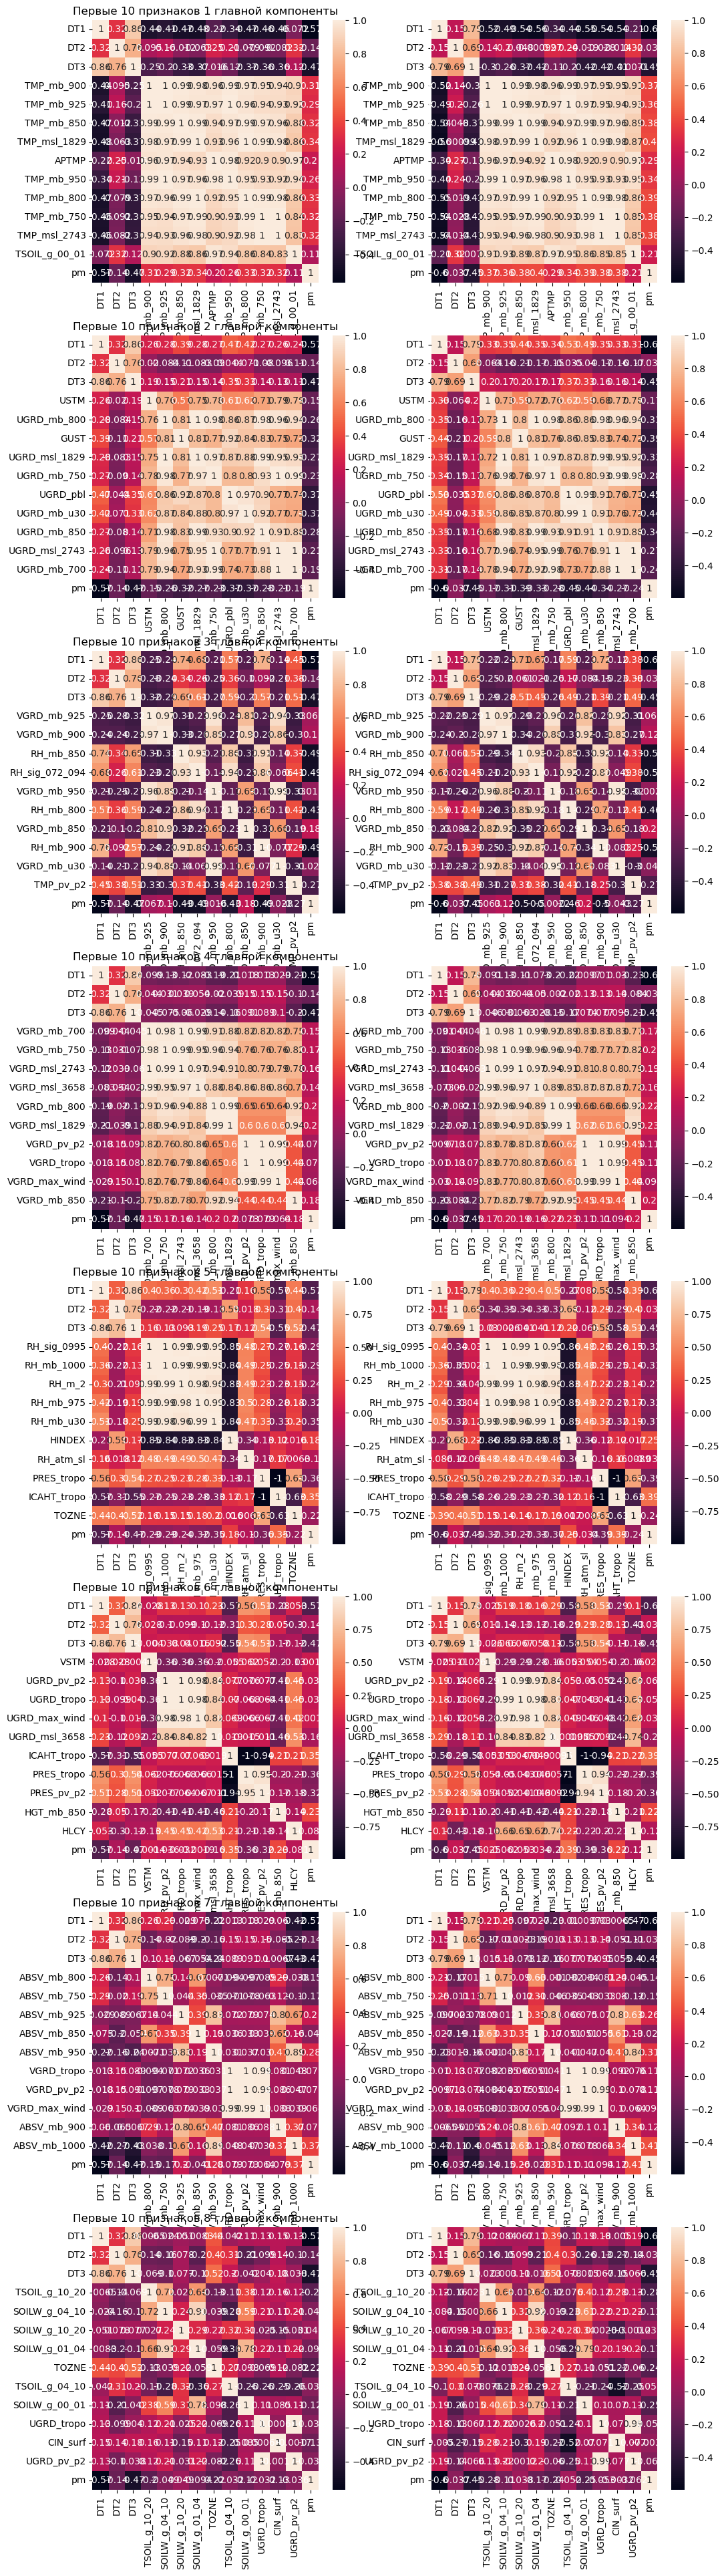

In [56]:
nf = 10 # Количество признаков
k = 8 # количество главных компонент

features = []

plt.figure(figsize = (12, 6*k))
for i in range(k):
    feati = ['DT1', 'DT2', 'DT3'] # Добавление инверсий
    # Признаки i-й главной компоненты 
    for feat in list(weights_k.sort_values(by=f'{i+1} компонента', ascending=False).iloc[:, [0, 1]].index[:nf]):
        feati.append(feat)
        
    tdf = df.loc[data.index][feati]
    tdf['pm'] = pm.loc[data.index]
    
    #sns.heatmap(tdf.corr(), annot = True)
    
    #plt.show()
    
    # Корреляции Пирсона (слева) и Спирмена (справа)
    plt.subplot(k, 2, 2*i+1)
    sns.heatmap(tdf.corr(), annot = True)
    
    plt.title(f'Первые {nf} признаков {i+1} главной компоненты')
    
    plt.subplot(k, 2, 2*i+2)
    spear = tdf.corr(method = 'spearman')
    sns.heatmap(spear, annot = True)
    
    # Отбор признаков
    featureSelect(spear, features)
    
#plt.show()

# Заключительный отбор для всех отобранный признаков
tdf = df.loc[data.index][features]
features = []
tdf['pm'] = pm.loc[data.index]
featureSelect(tdf.corr(method = 'spearman'), features)

In [57]:
features

['DT1',
 'UGRD_pbl',
 'TMP_msl_1829',
 'PRES_tropo',
 'RH_mb_u30',
 'TSOIL_g_10_20',
 'SOILW_g_00_01',
 'VGRD_msl_1829',
 'HGT_mb_850']

### Построение моделей

In [58]:
X_c = data[features]
X_c['pm'] = pm
X_c.dropna(inplace = True)

resultDfs = BuildModels(X_c, modelType = 'xgbReg', testSeason = season)

,Train,CV,Test
"{'learning_rate': 0.1, 'n_estimators': 100}",,,
MSE,35.50,47.00,31.26
MAE,4.61,5.32,4.59
MAPE,0.43,0.50,0.43
R2,0.32,-0.58,0.29
R2_adj,0.30,NaN,0.06


### Сохранение в таблицу

In [59]:
# Сохранение в файл
SaveResults('Results/', fileName, resultDfs, sheetName = f'по {nf} признаков {k} компонент',
            features = features, corr = X_c.corr(method = 'spearman')['pm'][:-1])